---
description: Dealing with transformations (groups, appending, replacing, freezing).
---

# Advanced Transformations
AvalancheDataset (and its subclasses like the Avalanche*Tensor/Subset/Concat*Dataset) allow for a finer control over transformations. While torchvision (and other) datasets allow for a minimal mechanism to apply transformations, with AvalancheDataset one can:
1. Have multiple **transformation "groups"** in the same dataset (like separated train and test transformations).
2. **Append, replace and remove transformations**, even by using nested Subset/Concat Datasets.
3. **Freeze transformations**, so that they can't be changed.

The following sub-sections show examples on how to use these features. Please note that all the constructor parameters and the methods described in this How-To can be used on AvalancheDataset subclasses as well. For more info on all the available subclasses, refer to [this Mini How-To](https://avalanche.continualai.org/how-tos/avalanchedataset/creating-avalanchedatasets).

It is warmly recommended to **run this page as a notebook** using Colab (info at the bottom of this page).

Let's start by installing Avalanche:

In [ ]:
!pip install avalanche-lib

## Transformation groups
AvalancheDatasets can contain multiple **transformation groups**. This can be useful to keep train and test transformations in the same dataset and to have different set of transformations. This may come in handy in many situations (for instance, to apply ad-hoc transformations to replay data).

As in torchvision datasets, AvalancheDataset supports the two kind of transformations: the `transform`, which is applied to X values, and the `target_transform`, which is applied to Y values. The latter is rarely used. This means that **a transformation group is a pair of transformations to be applied to the X and Y values** of each instance returned by the dataset. In both torchvision and Avalanche implementations, **a transformation must be a function (or other callable object)** that accepts one input (the X or Y value) and outputs its transformed version. This pair of functions is stored in the `transform` and `target_transform` fields of the dataset. A comprehensive guide on transformations can be found in the [torchvision documentation](https://pytorch.org/vision/stable/transforms.html).

In the following example, a MNIST dataset is created and then wrapped in an AvalancheDataset. When creating the AvalancheDataset, we can set *train* and *eval* transformations by passing a *transform\_groups* parameter. Train transformations usually include some form of random augmentation, while eval transformations usually include a sequence of deterministic transformations only. Here we define the sequence of train transformations as a random rotation followed by the ToTensor operation. The eval transformations only include the ToTensor operation.

In [2]:
from torchvision import transforms
from torchvision.datasets import MNIST
from avalanche.benchmarks.utils import AvalancheDataset

mnist_dataset = MNIST('mnist_data', download=True)

# Define the training transformation for X values
train_transformation = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.ToTensor(),
])
# Define the training transformation for Y values (rarely used)
train_target_transformation = None

# Define the test transformation for X values
eval_transformation = transforms.ToTensor()
# Define the test transformation for Y values (rarely used)
eval_target_transformation = None

transform_groups = {
    'train': (train_transformation, train_target_transformation),
    'eval': (eval_transformation, eval_target_transformation)
}

avl_mnist_transform = AvalancheDataset(mnist_dataset, transform_groups=transform_groups)

Of course, one can also just use the `transform` and `target_transform` constructor parameters to set the transformations for both the *train* and the *eval* groups. However, it is recommended to use the approach based on *transform\_groups* (shown in the code above) as it is much more flexible.

In [3]:
# Not recommended: use transform_groups instead
avl_mnist_same_transforms =  AvalancheDataset(mnist_dataset, transform=train_transformation)

### Using `.train()` and `.eval()`

**The default behaviour of the AvalancheDataset is to use transformations from the _train_ group.** However, one can easily obtain a version of the dataset where the *eval* group is used. Note: when obtaining the dataset of experiences from the test stream, those datasets will already be using the *eval* group of transformations so you don't need to switch to the eval group ;).

As noted before, transformations for the current group are loaded in the `transform` and `target_transform` fields. These fields can be changed directly, but this is *NOT* recommended, as this will not create a copy of the dataset and may probably affect other parts of the code in which the dataset is used.

The recommended way to switch between the *train* and *eval* groups is to use the `.train()` and `.eval()` methods to obtain a copy (view) of the dataset with the proper transformations enabled. This is another very handy feature of the AvalancheDataset: **methods that manipulate the AvalancheDataset fields (and transformations) always create a view of the dataset. The original dataset is never changed.**

In the following cell we use the *avl\_mnist\_transform* dataset created in the cells above. We first obtain a view of it in which *eval* transformations are enabled. Then, starting from this view, we obtain a version of it in which *train* transformations are enabled. We want to double-stress that `.train()` and `.eval()` never change the group of the dataset on which they are called: they always create a view.

One can check that the correct transformation group is in use by looking at the content of the *transform/target_transform* fields.

In [4]:
# Obtain a view of the dataset in which eval transformations are enabled
avl_mnist_eval = avl_mnist_transform.eval()

# Obtain a view of the dataset in which we get back to train transforms
# Basically, avl_mnist_transform ~= avl_mnist_train
avl_mnist_train = avl_mnist_eval.train()

# Check the current transformations function for the 3 datasets
print('Original dataset transformation:', avl_mnist_transform.transform)
# Output:
# Original dataset transformation: Compose(
#     RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
#     ToTensor()
# )
print('--------------------------------')
print('Eval version of the dataset:', avl_mnist_eval.transform)
# Output: "Eval version of the dataset: ToTensor()"
print('--------------------------------')
print('Back to train transformations:', avl_mnist_train.transform)
# Output:
# Back to train transformations: Compose(
#     RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
#     ToTensor()
# )

Original dataset transformation: Compose(
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)
--------------------------------
Eval version of the dataset: ToTensor()
--------------------------------
Back to train transformations: Compose(
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)


### Custom transformation groups
In *AvalancheDataset*s the **_train_ and _eval_ transformation groups are always available**. However, *AvalancheDataset* also supports **custom transformation groups**.

The following example shows how to create an AvalancheDataset with an additional group named *replay*. We define the replay transformation as a random crop followed by the ToTensor operation.

In [5]:
replay_transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor()
])

replay_target_transform = None

transform_groups_with_replay = {
    'train': (None, None),
    'eval': (None, None),
    'replay': (replay_transform, replay_target_transform)
}

AvalancheDataset(mnist_dataset, transform_groups=transform_groups_with_replay)

However, once created the dataset will use the *train* group. There are two ways to **switch to our custom group**:
- Set the group when creating the dataset using the `initial_transform_group` constructor parameter
- Switch to the group using the `.with_transforms(group_name)` method

The `.with_transforms(group_name)` method behaves in the same way `.train()` and `.eval()` do by creating a view of the original dataset.

The following example shows how to use both methods:

In [6]:
# Method 1: create the dataset with "replay" as the default group
avl_mnist_custom_transform_1 = AvalancheDataset(
    mnist_dataset,
    transform_groups=transform_groups_with_replay,
    initial_transform_group='replay')

print(avl_mnist_custom_transform_1.transform)

# Method 2: switch to "replay" using `.with_transforms(group_name)`
avl_mnist_custom_transform_not_enabled = AvalancheDataset(
    mnist_dataset,
    transform_groups=transform_groups_with_replay)

avl_mnist_custom_transform_2 = avl_mnist_custom_transform_not_enabled.with_transforms('replay')
print(avl_mnist_custom_transform_2.transform)

# Both prints output:
# Compose(
#     RandomCrop(size=(28, 28), padding=4)
#     ToTensor()
# )

Compose(
    RandomCrop(size=(28, 28), padding=4)
    ToTensor()
)
Compose(
    RandomCrop(size=(28, 28), padding=4)
    ToTensor()
)


## Appending transformations

In the standard torchvision datasets the only way to append (that is, add a new transformation step to the list of existing one) is to change the *transform* field directly by doing something like this:

In [7]:
# Append a transform by using torchvision datasets (>>> DON'T DO THIS! <<<)

# Create the dataset
mnist_dataset_w_totensor = MNIST('mnist_data', download=True, transform=transforms.ToTensor())

# Append a transform
to_append_transform = transforms.RandomCrop(size=(28, 28), padding=4)
mnist_dataset_w_totensor.transform = transforms.Compose(
    [mnist_dataset_w_totensor.transform, to_append_transform]
)
print(mnist_dataset_w_totensor.transform)
# Prints:
# Compose(
#     ToTensor()
#     RandomCrop(size=(28, 28), padding=4)
# )

Compose(
    ToTensor()
    RandomCrop(size=(28, 28), padding=4)
)


This solution has many huge drawbacks:
- The transformation field of the dataset is changed directly. This will affect other parts of the code that use that dataset instance.
- If the initial transform is `None`, then `Compose` will not complain, but the process will crash later (try it by yourself: replace the first element of Compose in cell above with `None`, then try obtaining a data point from the dataset).
- If you need to change transformations only temporarly to do some specific things in a limited part of the code, then you need to store the previous set of transformations in some variable in order to switch back to them later.

AvalancheDataset offers a very simple method to append transformations without incurring in those issues. The `.add_transforms(transform=None, target_transform=None)` method will append the given transform(s) **to the currently enabled transform group** and will return a new (a view actually) dataset with given transformations appended to the existing ones. The original dataset is not affected. One can also use `.add_transforms_to_group(group_name, transform, target_transform)` to change transformations for a different group.

The next cell shows how to use `.add_transforms(...)` to append the *to\_append\_transform* transform defined in the cell above.

In [8]:
# Create the dataset
avl_mnist = AvalancheDataset(MNIST('mnist_data', download=True), transform=transforms.ToTensor())

# Append a transformation. Simple as:
avl_mnist_appended_transform = avl_mnist.add_transforms(to_append_transform)

print('With appended transforms:', avl_mnist_appended_transform.transform)
# Prints:
# With appended transforms: Compose(
#     ToTensor()
#     RandomCrop(size=(28, 28), padding=4)
# )

# Check that the original dataset was not affected:
print('Original dataset:', avl_mnist.transform)
# Prints: "Original dataset: ToTensor()"

With appended transforms: Compose(
    ToTensor()
    RandomCrop(size=(28, 28), padding=4)
)
Original dataset: ToTensor()


Note that by using `.add_transforms(...)`:

- The original dataset is not changed, which means that other parts of the code that use that dataset instance are not affected.
- You don't need to worry about *None* transformations.
- In order to revert to the original transformations you don't need to keep a copy of them: the original dataset is not affected!

## Replacing transformations

The replacement operation follows the same idea (and benefits) of the append one. By using `.replace_transforms(transform, target_transform)` one can obtain a view of the original dataset in which the **transformaations for the current group** are replaced with the given ones. One may also change tranformations for other groups by passing the name of the group as the optional parameter `group`. As with any transform-related operation, the original dataset is not affected. 

Note: one can use `.replace_transforms(...)` to remove previous transformations (by passing `None` as the new transform).

The following cell shows how to use `.replace_transforms(...)` to replace the transformations of the current group:

In [9]:
new_transform = transforms.RandomCrop(size=(28, 28), padding=4)

# Append a transformation. Simple as:
avl_mnist_replaced_transform = avl_mnist.replace_transforms(new_transform, None)

print('With replaced transform:', avl_mnist_replaced_transform.transform)
# Prints: "With replaces transforms: RandomCrop(size=(28, 28), padding=4)"

# Check that the original dataset was not affected:
print('Original dataset:', avl_mnist.transform)
# Prints: "Original dataset: ToTensor()"

With replaced transform: RandomCrop(size=(28, 28), padding=4)
Original dataset: ToTensor()


## Freezing transformations

One last functionality regarding transformations is the ability to "freeze" transformations. Freezing transformations menas **permanently glueing transformations to the dataset so that they can't be replaced or changed in any way** (usually by mistake). Frozen transformations cannot be changed by using `.replace_transforms(...)` or even by changing the `transform` field directly.

One may wonder when this may come in handy... in fact, you will probably rarely need to freeze transformations. However, imagine having to instantiate the PermutedMNIST benchmark. You want the permutation transformation to not be changed by mistake. However, the end users do not know how the internal implementations of the benchmark works, so they may end up messing with those transformations. By freezing the permutation transformation, users cannot mess with it.

Transformations for all transform groups can be frozen at once by using `.freeze_transforms()`. Transformations can be frozen for a single group by using `.freeze_group_transforms(group_name)`. As always, those methods return a view of the original dataset.

The cell below shows a simplified excerpt from the [PermutedMNIST benchmark implementation](https://github.com/ContinualAI/avalanche/blob/master/avalanche/benchmarks/classic/cmnist.py). First, a *PixelsPermutation* instance is created. That instance is a transformation that will permute the pixels of the input image. We then create the train end test sets. Once created, transformations for those datasets are frozen using `.freeze_transforms()`.

In [10]:
from avalanche.benchmarks.classic.cmnist import PixelsPermutation
import numpy as np
import torch

# Instantiate MNIST train and test sets
mnist_train = MNIST('mnist_data', train=True, download=True)
mnist_test = MNIST('mnist_data', train=False, download=True)
    
# Define the transformation used to permute the pixels
rng_seed = 4321
rng_permute = np.random.RandomState(rng_seed)
idx_permute = torch.from_numpy(rng_permute.permutation(784)).type(torch.int64)
permutation_transform = PixelsPermutation(idx_permute)

# Define the transforms group
perm_group_transforms = dict(
    train=(permutation_transform, None),
    eval=(permutation_transform, None)
)

# Create the datasets and freeze transforms
# Note: one can call "freeze_transforms" on constructor result
# or you can do this in 2 steps. The result is the same (obviously).
# The next part show both ways:

# Train set
permuted_train_set = AvalancheDataset(
    mnist_train, 
    transform_groups=perm_group_transforms).freeze_transforms()

# Test set
permuted_test_set = AvalancheDataset(
    mnist_test, transform_groups=perm_group_transforms, 
    initial_transform_group='eval')
permuted_test_set = permuted_test_set.freeze_transforms()

In this way, that transform can't be removed. However, remember that one can always append other transforms atop of frozen transforms.

The cell below shows that `replace_transforms` can't remove frozen transformations:

Before replace_transforms:


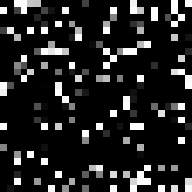

After replace_transforms:


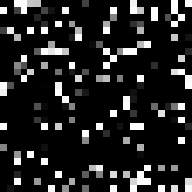

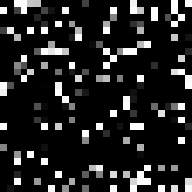

In [11]:
# First, show that the image pixels are permuted
print('Before replace_transforms:')
display(permuted_train_set[0][0].resize((192, 192), 0))

# Try to remove the permutation
with_removed_transforms = permuted_train_set.replace_transforms(None, None)

print('After replace_transforms:')
display(permuted_train_set[0][0].resize((192, 192), 0))
display(with_removed_transforms[0][0].resize((192, 192), 0))

## Transformations wrap-up
This completes the *Mini How-To* for the functionalities of the *AvalancheDataset* related to **transformations**. 

Here you learned how to use **transformation groups** and how to **append/replace/freeze transformations** in a simple way.

Other *Mini How-To*s will guide you through the other functionalities offered by the *AvalancheDataset* class. The list of *Mini How-To*s can be found [here](https://avalanche.continualai.org/how-tos/avalanchedataset).

## 🤝 Run it on Google Colab

You can run _this chapter_ and play with it on Google Colaboratory by clicking here: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ContinualAI/avalanche/blob/master/notebooks/how-tos/avalanchedataset/advanced-transformations.ipynb)